<a href="https://colab.research.google.com/github/jaison-leonardo/house-predictor-ML/blob/main/Taller_1_IA2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

EDA
1. Limpieza
1.1 null
1.1 outliers
2. Preprocesamiento
2.2 Tipo de datos
2.3 Tipo de
3. Transformación
4. Balanceo
4.1
4.2 Skewness
5. Correlation coefficient
6. MSE, MAE, R2, test
7. CV, K-fold
8. Grid search


In [ ]:
import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import KFold, cross_val_score
import numpy as np

from sklearn.model_selection import GridSearchCV

In [ ]:
path = kagglehub.dataset_download("harlfoxem/housesalesprediction")
df_reg = pd.read_csv(path + "/kc_house_data.csv")
df_reg.info()

data_null = df_reg.isnull().sum().sort_values(ascending=False)
# Limpieza
print("data_null")
display(data_null[data_null > 0])

num_cols = df_reg.select_dtypes(include=np.number).columns.to_list()
cat_cols = df_reg.select_dtypes(exclude=np.number).columns.to_list()
display("num_cols",num_cols)
display("cat_cols",cat_cols)
"""
Observamos 20 columnas númericas que  incluyen tanto variables continuas
 como price, sqft_living, lat como categóricas codificadas como números
 (zipcode, condition, grade, view, waterfront).
 y una Categórica date, que está como object, ademas no hay nulos
"""

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

,0


'num_cols'

['id',
 'price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15']

'cat_cols'

['date']

| Columna         | Descripción                                                                 |
|-----------------|------------------------------------------------------------------------------|
| id              | ID único para cada casa vendida                                              |
| date            | Fecha de la venta de la casa                                                 |
| price           | Precio de la casa vendida                                                    |
| bedrooms        | Número de habitaciones                                                       |
| bathrooms       | Número de baños                                                              |
| sqft_living     | Metros cuadrados del área habitable                                           |
| sqft_lot        | Metros cuadrados del terreno                                                 |
| floors          | Número de pisos                                                              |
| waterfront      | Indica si la casa tiene vista al agua (0 = No, 1 = Sí)                       |
| view            | Puntos de vista otorgados según el sistema de calificación del condado King  |
| condition       | Condición de la casa (calificada de 1 a 5)                                   |
| grade           | Calificación de la casa según construcción y diseño                          |
| sqft_above      | Metros cuadrados sobre el nivel del suelo                                    |
| sqft_basement   | Metros cuadrados del sótano                                                  |
| yr_built        | Año en que fue construida la casa                                            |
| yr_renovated    | Año en que la casa fue renovada (0 si nunca ha sido renovada)                |
| zipcode         | Código postal de la ubicación de la casa                                     |
| lat             | Latitud de la ubicación de la casa                                           |
| long            | Longitud de la ubicación de la casa                                          |
| sqft_living15   | Metros cuadrados del área habitable de los 15 vecinos más cercanos           |
| sqft_lot15      | Metros cuadrados del terreno de los 15 vecinos más cercanos                  |


<Axes: >

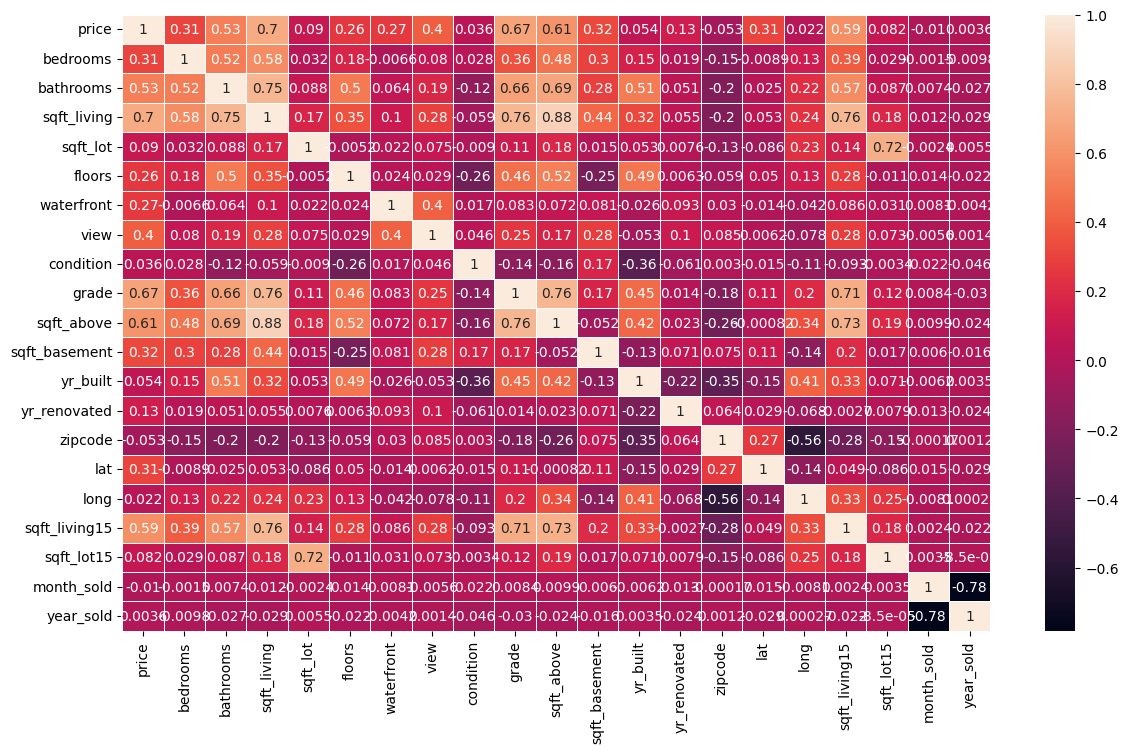

In [ ]:
"""
Observamos la matriz de correlación
"""

plt.figure(figsize = (14,8))
sns.heatmap(df_reg.corr(), linewidths = 0.5, annot = True)

In [ ]:
"""
Tambien encontramos la correlación del precio con las demas caracteristicas
"""

df_reg.corr()["price"].sort_values(ascending = False)

,price
price,1.000000
sqft_living,0.702035
grade,0.667434
sqft_above,0.605567
sqft_living15,0.585379
bathrooms,0.525138
view,0.397293
sqft_basement,0.323816
bedrooms,0.308350
lat,0.307003


```
# **Valores desbalanceados, sesgados (skewed) y atipicos (outliers)**
```



Skewness de 'price': 1.5329784547427958


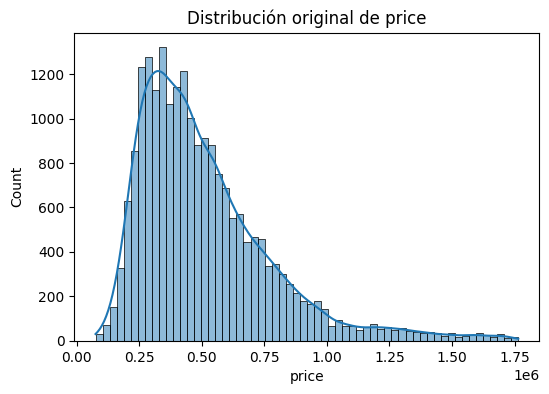

In [ ]:
"""
Skewness del target
"""
target = "price"

print("Skewness de 'price':", df_reg[target].skew())

# Histograma normal
plt.figure(figsize=(6,4))
sns.histplot(df_reg[target], bins=60, kde=True)
plt.title("Distribución original de " + target)
plt.show()
"""
Encontramos que alrededor de 2.5 millones los valores no son relevantes
"""
t = 2.5*10**6
df_reg = df_reg[df_reg[target]<= t]


In [ ]:
"""
Encontramos que id, date y zipccode, no aportan en la matriz de correlación
los eliminamos
"""
df_reg = df_reg.drop(['id','date', 'zipcode'], axis = 1)

In [ ]:
"""
Outliers con IQR (Interquartile Range)
COlumnas númericas con más ourliers
"""
def iqr_outlier_count(s: pd.Series):
    q1, q3 = np.percentile(s.dropna(), [25, 75])
    iqr = q3 - q1
    low, high = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    return ((s < low) | (s > high)).sum()

outlier_counts = pd.Series({
    c: iqr_outlier_count(df_reg[c]) for c in df_reg.select_dtypes(include=np.number).columns if c != target
}).sort_values(ascending=False)

print("Cantidad de outliers por variable:")
display(outlier_counts.head(10))


Cantidad de outliers por variable:


,0
sqft_lot,2425
sqft_lot15,2194
view,2124
grade,1911
yr_renovated,914
sqft_above,611
sqft_living,572
bathrooms,571
bedrooms,546
sqft_living15,544


Top 5 variables con más outliers: ['sqft_lot', 'sqft_lot15', 'view', 'grade', 'yr_renovated']


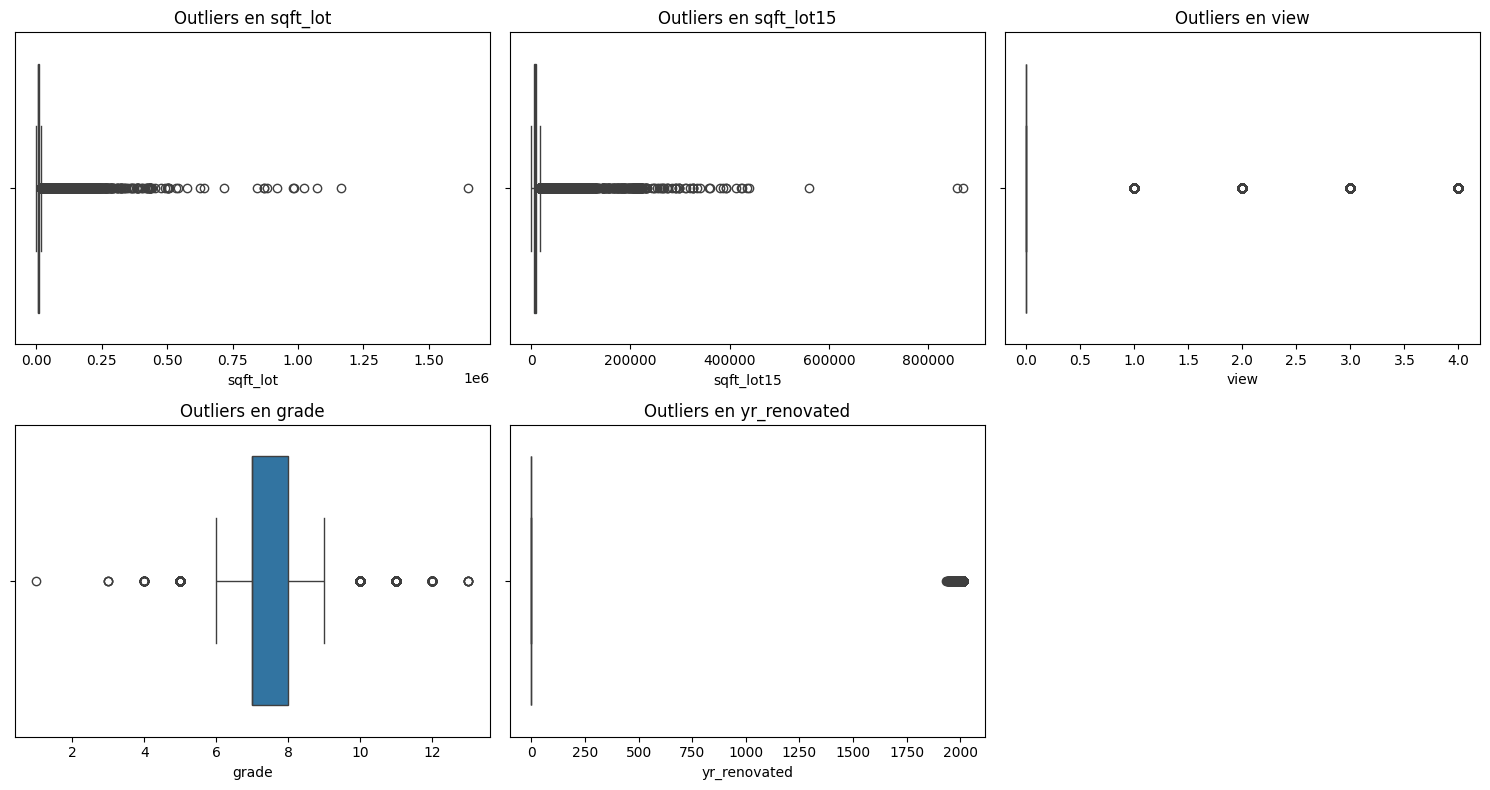

In [ ]:
"""
Representamos los outliers con boxplots
"""
top_outliers = outlier_counts.head(5).index.tolist()
print("Top 5 variables con más outliers:", top_outliers)

# Graficar boxplots en subplots
plt.figure(figsize=(15, 8))

for i, col in enumerate(top_outliers, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=df_reg[col])
    plt.title(f"Outliers en {col}")

plt.tight_layout()
plt.show()


In [ ]:
"""
Eliminamos los valores extramos y Winsorización (capping) de los outliers para
eliminar los valores extremos y evitar sesgos en el modelo 1% a 99%
"""
df_reg = df_reg[df_reg[target] < df_reg[target].quantile(0.99)]
# Capping
for col in ['sqft_lot', 'sqft_lot15']:
    low, high = df_reg[col].quantile([0.01, 0.99])
    df_reg[col] = df_reg[col].clip(lower=low, upper=high)

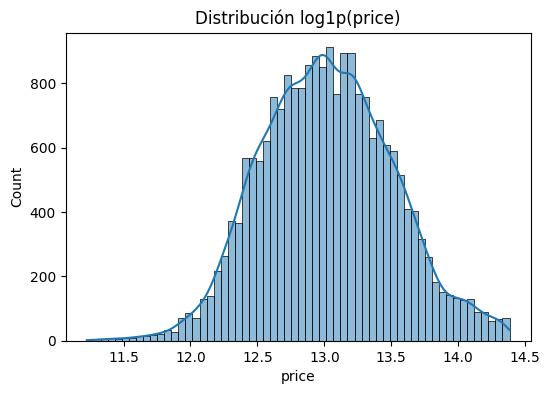

In [ ]:
"""
Trasnformamos el target con log1p para tener una distribución normal
"""
# Histograma log-transformado
plt.figure(figsize=(6,4))
sns.histplot(np.log1p(df_reg[target]), bins=60, kde=True)
plt.title("Distribución log1p(price)")
plt.show()

df_reg['price_log'] = np.log1p(df_reg['price'])

Train shape: (14484, 22)
Test shape : (6816, 22)


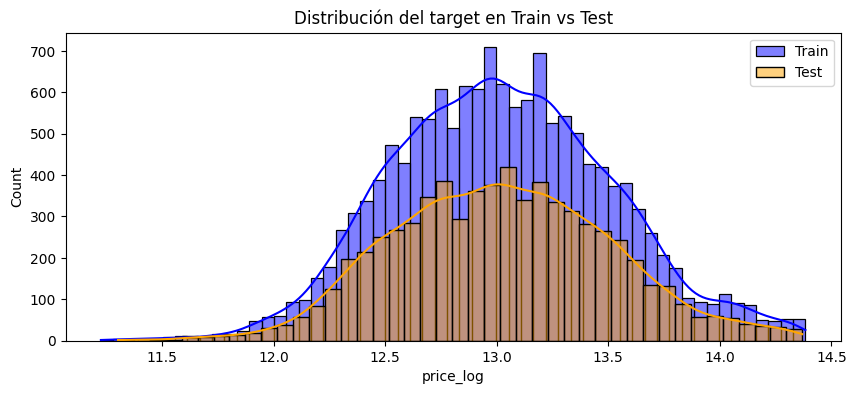

In [ ]:
"""
Estratificamos y dividimos el dataset en train y test
Para garantizar que train y test tengan distribuciones similares del target
"""
df_reg['price_bin'] = pd.qcut(df_reg['price_log'], q=5, labels=False,
                              duplicates='drop')

# Split estratificado 68/32
TEST_PCT = 0.32
splitter = StratifiedShuffleSplit(n_splits=1, test_size=TEST_PCT,
                                  random_state=42)

for train_idx, test_idx in splitter.split(df_reg, df_reg['price_bin']):
    train_df = df_reg.iloc[train_idx].drop(columns=['price_bin'])
    test_df  = df_reg.iloc[test_idx].drop(columns=['price_bin'])

print("Train shape:", train_df.shape)
print("Test shape :", test_df.shape)

# Verificar que la distribución del target es parecida en ambos subconjuntos
plt.figure(figsize=(10,4))
sns.histplot(train_df['price_log'], color="blue", label="Train", kde=True)
sns.histplot(test_df['price_log'], color="orange", label="Test", kde=True)
plt.legend()
plt.title("Distribución del target en Train vs Test")
plt.show()

In [ ]:
"""
Escalado de variables para que todas tengan la misma escala
"""
# Definir target
y_train = train_df['price_log'].values
y_test  = test_df['price_log'].values

# Features excluyendo price y price_log
X_train = train_df.drop(columns=['price','price_log'])
X_test  = test_df.drop(columns=['price','price_log'])

# Variables categóricas y numéricas
cat_features = ['waterfront', 'view', 'condition', 'grade']
num_features = [c for c in X_train.columns if c not in cat_features]

# Ajustamos y transformamos
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ]
)

# Ajustar y transformar
X_train_prepared = preprocessor.fit_transform(X_train)
X_test_prepared  = preprocessor.transform(X_test)

X_train_prepared.shape, X_test_prepared.shape


((14484, 39), (6816, 39))

In [ ]:
# Definición y entrenamiento de redes neuronales
"""
Modelo 1 (Baseline):
Hiperparámetros:
 - 2 capas ocultas (64, 32)
 - Activación ReLU
 - Batch size 32
 - learning rate 0.001
 - epochs 50.
"""
input_dim = X_train_prepared.shape[1]

def build_model_1():
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(1, activation="linear")
    ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                  loss="mse",
                  metrics=["mae", "mse"])
    return model

model1 = build_model_1()
history1 = model1.fit(
    X_train_prepared, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50
363/363 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 55.8458 - mae: 5.6368 - mse: 55.8458 - val_loss: 0.8118 - val_mae: 0.6407 - val_mse: 0.8118
Epoch 2/50
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6531 - mae: 0.5786 - mse: 0.6531 - val_loss: 0.3245 - val_mae: 0.4297 - val_mse: 0.3245
Epoch 3/50
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2681 - mae: 0.3900 - mse: 0.2681 - val_loss: 0.1862 - val_mae: 0.3256 - val_mse: 0.1862
Epoch 4/50
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1639 - mae: 0.3057 - mse: 0.1639 - val_loss: 0.1294 - val_mae: 0.2773 - val_mse: 0.1294
Epoch 5/50
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1142 - mae: 0.2600 - mse: 0.1142 - val_loss: 0.0994 - val_mae: 0.2410 - val_mse: 0.0994
Epoch 6/50
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0928 - mae: 0.2338 - mse: 0.0928 - val_loss: 0.0802 - val_mae: 0.2159 - val_mse: 0.0802
Epoch 7/50
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0747 - mae: 0.2097 - mse: 0.0747 - v

In [ ]:
"""
Modelo 2 (Intermedio)
Hiperparámetros:
 - 3 capas ocultas (128, 64, 32)
 - Dropout 0.2
 - Batch size 32
 - Learning rate 0.001
 - Epochs 100
"""
def build_model_2():
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(64, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(1, activation="linear")
    ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                  loss="mse",
                  metrics=["mae", "mse"])
    return model

model2 = build_model_2()
history2 = model2.fit(
    X_train_prepared, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    verbose=1
)


Epoch 1/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 44.1544 - mae: 4.6075 - mse: 44.1544 - val_loss: 0.5183 - val_mae: 0.5225 - val_mse: 0.5183
Epoch 2/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0931 - mae: 0.8185 - mse: 1.0931 - val_loss: 0.2118 - val_mae: 0.3436 - val_mse: 0.2118
Epoch 3/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7561 - mae: 0.6868 - mse: 0.7561 - val_loss: 0.2671 - val_mae: 0.4303 - val_mse: 0.2671
Epoch 4/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6173 - mae: 0.6194 - mse: 0.6173 - val_loss: 0.3299 - val_mae: 0.5008 - val_mse: 0.3299
Epoch 5/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4949 - mae: 0.5550 - mse: 0.4949 - val_loss: 0.3474 - val_mae: 0.5288 - val_mse: 0.3474
Epoch 6/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4087 - mae: 0.5058 - mse: 0.4087 - val_loss: 0.6287 - val_mae: 0.7456 - val_mse: 0.6287
Epoch 7/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3359 - mae: 0.4572 - mse: 0.3

In [ ]:
"""
Modelo 3 (Avanzado)
Hiperparámetros:
 - 4 capas ocultas (256, 128, 64, 32)
 - Batch normalization
 - Dropout 0.3
 - Optimizer Adam con lr=0.0005
 - Epochs 150.
"""
def build_model_3():
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(256, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(128, activation="relu"),
        layers.BatchNormalization(),
        layers.Dense(64, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(1, activation="linear")
    ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005),
                  loss="mse",
                  metrics=["mae", "mse"])
    return model

model3 = build_model_3()
history3 = model3.fit(
    X_train_prepared, y_train,
    validation_split=0.2,
    epochs=150,
    batch_size=32,
    verbose=1
)


Epoch 1/150
363/363 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 53.3945 - mae: 5.5212 - mse: 53.3945 - val_loss: 1.0647 - val_mae: 0.8542 - val_mse: 1.0647
Epoch 2/150
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.8345 - mae: 0.7200 - mse: 0.8345 - val_loss: 0.4218 - val_mae: 0.4253 - val_mse: 0.4218
Epoch 3/150
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.5651 - mae: 0.5916 - mse: 0.5651 - val_loss: 0.3786 - val_mae: 0.4091 - val_mse: 0.3786
Epoch 4/150
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4479 - mae: 0.5295 - mse: 0.4479 - val_loss: 0.3545 - val_mae: 0.3854 - val_mse: 0.3545
Epoch 5/150
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3537 - mae: 0.4714 - mse: 0.3537 - val_loss: 0.3322 - val_mae: 0.4089 - val_mse: 0.3322
Epoch 6/150
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3297 - mae: 0.4524 - mse: 0.3297 - val_loss: 0.2746 - val_mae: 0.3646 - val_mse: 0.2746
Epoch 7/150
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3039 - mae: 0.4375 - mse: 0.3

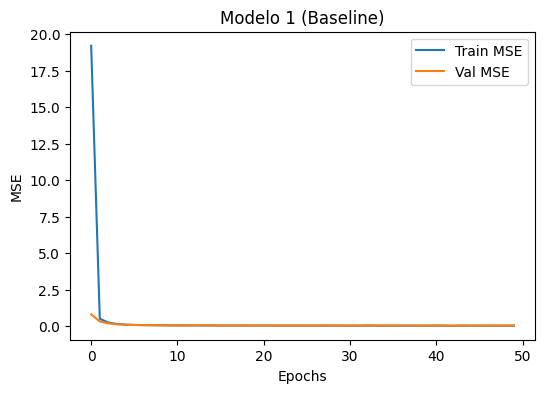

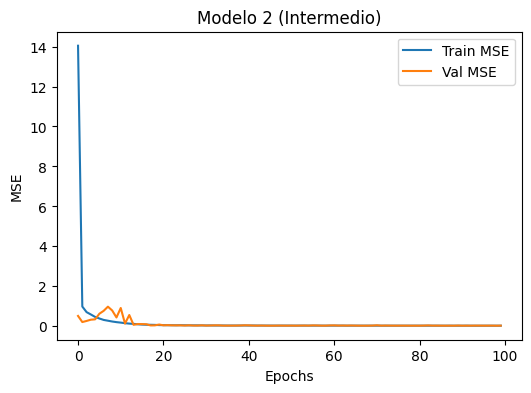

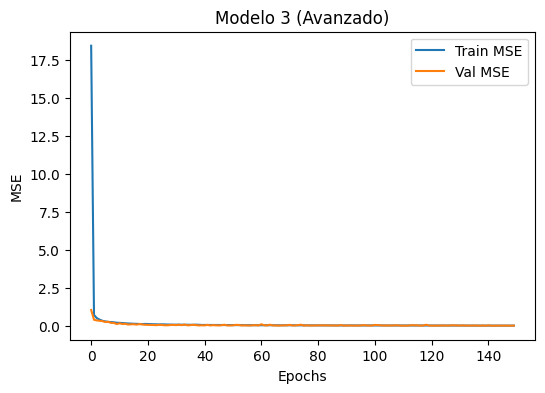

In [ ]:
"""
Evolución de los modelos en loss y val_loss en cada epoca
"""
def plot_history(history, title):
    plt.figure(figsize=(6,4))
    plt.plot(history.history['mse'], label="Train MSE")
    plt.plot(history.history['val_mse'], label="Val MSE")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("MSE")
    plt.legend()
    plt.show()

plot_history(history1, "Modelo 1 (Baseline)")
plot_history(history2, "Modelo 2 (Intermedio)")
plot_history(history3, "Modelo 3 (Avanzado)")


In [ ]:
def evaluar_modelo(nombre, modelo, X_test, y_test):
    y_pred = modelo.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2  = r2_score(y_test, y_pred)
    return {"Modelo": nombre, "MSE": mse, "MAE": mae, "R2": r2}

resultados = []

# Random Forest Regressor
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    random_state=42
)
rf_model.fit(X_train_prepared, y_train)

# Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)
gb_model.fit(X_train_prepared, y_train)

# XGBoost Regressor
xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train_prepared, y_train)

"""
Evaluación de los modelos ya entrenados anteriormente
"""
for i, model in enumerate([model1, model2, model3], start=1):
    y_pred = model.predict(X_test_prepared).flatten()
    resultados.append({
        "Modelo": f"NN_{i}",
        "MSE": mean_squared_error(y_test, y_pred),
        "MAE": mean_absolute_error(y_test, y_pred),
        "R2": r2_score(y_test, y_pred)
    })

"""
Evaluación de los modelos Random Forest, Gradient Boosting y XGBoost Ensembles
"""
resultados.append(evaluar_modelo("RandomForest",
                                 rf_model, X_test_prepared, y_test))

resultados.append(evaluar_modelo("GradientBoosting",
                                 gb_model, X_test_prepared, y_test))

resultados.append(evaluar_modelo("XGBoost",
                                 xgb_model, X_test_prepared, y_test))

df_resultados = pd.DataFrame(resultados)
display(df_resultados)

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


,Modelo,MSE,MAE,R2
0,NN_1,0.059860,0.164419,0.749183
1,NN_2,0.037002,0.138588,0.844961
2,NN_3,0.044035,0.158503,0.815492
3,RandomForest,0.033909,0.133456,0.857922
4,GradientBoosting,0.028747,0.122484,0.879548
5,XGBoost,0.024969,0.112747,0.895378


Redes neuronales (NN)

* NN_1 (Baseline): R² ≈ 0.75
* NN_2 (Intermedia): R² ≈ 0.84
* NN_3 (Avanzada): R² ≈ 0.81
---
Ensembles
* Random Forest: R² ≈ 0.86
* Gradient Boosting: R² ≈ 0.87
* XGBoost: R² ≈ 0.89

In [ ]:
"""
Validación cruzada K-Fold
"""
def cross_validate_model(nombre, modelo, X, y, cv=3):
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    mse_scores = -cross_val_score(modelo, X, y, cv=kf, scoring="neg_mean_squared_error", n_jobs=-1)
    mae_scores = -cross_val_score(modelo, X, y, cv=kf, scoring="neg_mean_absolute_error", n_jobs=-1)
    r2_scores  = cross_val_score(modelo, X, y, cv=kf, scoring="r2", n_jobs=-1)
    return {
        "Modelo": nombre,
        "MSE_mean": mse_scores.mean(),
        "MAE_mean": mae_scores.mean(),
        "R2_mean": r2_scores.mean()
    }
# Todo para ensembles
rf_fast = RandomForestRegressor(n_estimators=100, max_depth=8, n_jobs=-1, random_state=42)
gb_fast = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
xgb_fast = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=3, subsample=0.8, colsample_bytree=0.8,
                        random_state=42, n_jobs=-1)
cv_results = []
cv_results.append(cross_validate_model("RandomForest_fast", rf_fast, X_train_prepared, y_train, cv=3))
cv_results.append(cross_validate_model("GradientBoosting_fast", gb_fast, X_train_prepared, y_train, cv=3))
cv_results.append(cross_validate_model("XGBoost_fast", xgb_fast, X_train_prepared, y_train, cv=3))

pd.DataFrame(cv_results)

,Modelo,MSE_mean,MAE_mean,R2_mean
0,RandomForest_fast,0.038359,0.142478,0.841599
1,GradientBoosting_fast,0.034209,0.135680,0.858736
2,XGBoost_fast,0.029469,0.124413,0.878291


In [ ]:
"""
GridSearchCV para XGBoost porqué fue el mejor anteriormente

param_grid = {
    "n_estimators": [200, 500],
    "learning_rate": [0.1, 0.05, 0.01],
    "max_depth": [3, 5, 7],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}
"""
# Un poco más eficiente para mostrar los resultados
param_grid = {
    "n_estimators": [100, 200],
    "learning_rate": [0.1, 0.05],
    "max_depth": [3, 5],
    "subsample": [0.8],
    "colsample_bytree": [0.8]
}

grid = GridSearchCV(
    estimator=XGBRegressor(random_state=42, n_jobs=-1),
    param_grid=param_grid,
    cv=3,
    scoring="r2",
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train_prepared, y_train)

print("Mejores hiperparámetros encontrados:")
print(grid.best_params_)
print("Mejor R² en CV:", grid.best_score_)

# Evaluar en test con el mejor modelo
best_xgb = grid.best_estimator_
y_pred = best_xgb.predict(X_test_prepared)

print("\nEvaluación en test:")
print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R2 :", r2_score(y_test, y_pred))

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Mejores hiperparámetros encontrados:
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Mejor R² en CV: 0.8896848946751569

Evaluación en test:
MSE: 0.025711819181894875
MAE: 0.11451026431466363
R2 : 0.8922669120679767
